# Intelligent Systems - Part 2
# Wrapper Methods and Feature Engineering

### Kasra Borazjani - 810196662
### Parmida Valiahdi - 810196586

# Phase 0: Downloading Data

Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/IS - Final Project

Cloning GitHub repository

In [ ]:
! git clone https://github.com/sowmyagowri/Drug-Activity-Prediction-Dorothea-Dataset.git
! git pull

# Phase 1: Pre-Processing

Importing the libraries needed

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

Train and test data path

In [3]:
traindatapath = 'Drug-Activity-Prediction-Dorothea-Dataset/train.dat'
testdatapath = 'Drug-Activity-Prediction-Dorothea-Dataset/test.dat'

Load and read the data:

In [4]:
def loadData2(trainingFile, testingFile):
    
    def convertDataframe(inputFile):
        data = pd.DataFrame(columns=range(100000))
        
        for i in range(len(inputFile)):
            record = np.fromstring(inputFile[i], dtype=int, sep=' ')
            record_bool = [0 for j in range(100000)]
            for col in record:
                record_bool[col-1] = 1
            
            data.loc[i] = record_bool
            
        return data
    
    with open(trainingFile, "r") as fr1:
        trainFile = fr1.readlines()
    
    #Split each line in the two files into label and data  
    train_data_list = []
    train_labels_list = []
    
    for inputData in trainFile:
        train_labels_list.append(inputData[0])
        
        #Remove the activity label (0/1) and new line character from each record
        inputData = inputData.replace("0\t", "")
        inputData = inputData.replace("1\t", "")
        inputData = inputData.replace("\n", "")
        train_data_list.append(inputData)
    
    train_labels = np.asarray(train_labels_list)
    train_data = convertDataframe(train_data_list)
        
    with open(testingFile, "r") as fr2:
        testFile = fr2.readlines()
    
    test_data = convertDataframe(testFile)
            
    return train_data, test_data, train_labels

In [5]:
new_train_data, new_test_data, new_train_labels = loadData2(traindatapath, testdatapath)
    

Downsample the majority class:

In [ ]:
newer_train_data = pd.DataFrame()

flag = 0
for i in range(len(new_train_data[0])):
  print("i equals: {}".format(i))
  if new_train_labels[i] == '0':
    if flag==78:
      continue
    flag += 1

  newer_train_data.append(new_train_data.iloc[i])



Save the loaded data into files in order to prevent reloading:

In [35]:
new_train_data.to_csv("new_train_data.csv", sep=",",header=None)
new_train_labels.tofile("new_train_labels.csv", sep=",")
new_test_data.to_csv("new_test_data.csv", sep=",", header=None)

Cast "int" type to train_labels

In [6]:
for i in range(len(new_train_labels)):
    new_train_labels[i] = int(new_train_labels[i])

load test labels:

In [7]:
testlabelpath = 'Drug-Activity-Prediction-Dorothea-Dataset/valid_labels.dat'
test_labels = pd.read_csv(testlabelpath, header=None)

# Phase 2: Testing the SVM

Define the SVM using standard scaler and SVC module in sklearn.svm

In [126]:


scaler = StandardScaler()
X_train = scaler.fit_transform(new_train_data)
X_test = scaler.transform(new_test_data)
y_train = new_train_labels.copy()

clf = SVC(kernel='linear', gamma=0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Measure accuracy for the trained SVM:

In [127]:


accuracy = np.count_nonzero((int(y_pred[0])==np.array(test_labels[0])).astype('uint8'))/ test_labels.shape[0] * 100
print(accuracy)

90.28571428571428


Get the predicted output readable for the confusion_matrix() function:

In [128]:
y = [int(y_pred[i]) for i in range(350)]

Plotting the confusion matrix:

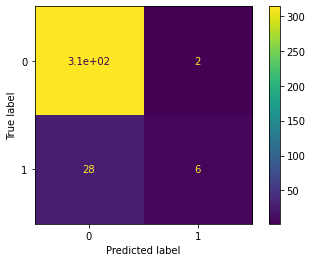

In [129]:

disp = ConfusionMatrixDisplay(confusion_matrix(test_labels, y, labels = [0,1], sample_weight=None, normalize = None), display_labels = [0,1])
disp.plot()

## Phase 3: Step-Forward Selection:

In this procedure, we train an SVM for each feature in our dataset in order to measure the accuracy of their prediction. The one with the highest accuracy will be added to the list of our most favourable features in order to eliminate the ones that do not make a noticable contribution to increasing the accuracy of our model. A variable "base_value" is selected to control how far this loop goes. Whenever there is no increase in the accuracy of our model, the while() loop will be broken and the procedure will finish.

In [115]:
def sfs(train_data, train_labels, test_data, test_labels):
  
  
  base_value = 0
  num_of_cols = len(train_data.columns)
  best_attribs = pd.DataFrame()
  test_data_test = pd.DataFrame()
  locs = [i for i in range(len(train_data.columns))]
  iteration = 1
  while(num_of_cols > 0):
      
      best_performance = 0
      best_attrib_index = 0
      for i in locs:
          temp_best_attribs = best_attribs.copy()
          temp_best_attribs.insert(value=train_data[i], loc=0, column=i)
          
          clf = SVC(kernel='linear', gamma=0.5)
          clf.fit(temp_best_attribs, train_labels)
          test_data_test_temp = test_data_test.copy()
          test_data_test_temp.insert(value=test_data[i], loc=0, column=i)
          y_pred = clf.predict(test_data_test_temp)
          accuracy = np.count_nonzero((int(y_pred[0])==np.array(test_labels[0])).astype('uint8'))/ test_labels.shape[0] * 100
          
          if (accuracy > best_performance):
            best_performance = accuracy
            best_attrib_index = locs.index(i)
      
      if (best_performance > base_value):
        base_value = best_performance
        best_attribs.insert(value=train_data[locs[best_attrib_index]], loc=0, column=locs[best_attrib_index])
        print("Iteration #{} complete. \n column {} was inserted \n".format(iteration, best_attrib_index))
        num_of_cols -= 1
        test_data_test.insert(value=test_data[locs[best_attrib_index]], loc=0, column=locs[best_attrib_index])
        locs.pop(best_attrib_index)
        iteration += 1

      else:
        print("Iteration #{} complete. No more columns to add. \n".format(iteration))
        break
      
  return best_attribs


The dataset has 100 thousand features, for which the training would take a fairly long time to complete. Therefore, we have chosen the first 100 for the sake of demonstration.

Iteration #1 complete. 
 column 0 was inserted 

Iteration #2 complete. No more columns to add.
the final columns are: 0 

accuracy is 90.28571428571428 percent! 



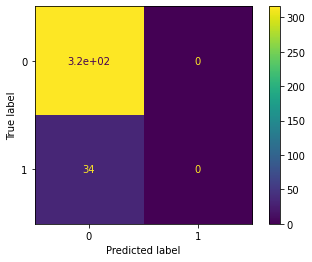

In [120]:
tr_data_sfs = new_train_data.copy()
tr_labels_sfs = new_train_labels.copy()
tst_data_sfs = new_test_data.copy()
tst_labels_sfs = test_labels.copy()

tr_data_sfs_test = tr_data_sfs[range(100)]
tst_data_sfs_test = tst_data_sfs[range(100)]


best_attribs_sfs = sfs(tr_data_sfs_test, tr_labels_sfs, tst_data_sfs_test, tst_labels_sfs)

print("the final columns are: {} \n".format(best_attribs_sfs.columns[0]))

train_data_final = tr_data_sfs_test[best_attribs_sfs.columns]

newsvm = SVC(kernel='linear', gamma=0.5)
newsvm.fit(train_data_final, tr_labels_sfs)
test_data_final = tst_data_sfs_test[best_attribs_sfs.columns]
y_pred = newsvm.predict(test_data_final)


accuracy = np.count_nonzero((int(y_pred[0])==np.array(test_labels[0])).astype('uint8'))/ test_labels.shape[0] * 100
print("accuracy is {} percent! \n".format(accuracy))

y = [int(y_pred[i]) for i in range(350)]

disp = ConfusionMatrixDisplay(confusion_matrix(test_labels, y, labels = [0,1], sample_weight=None, normalize = None), display_labels = [0,1])
disp.plot()

## Phase 4: Backward Elimination Selection

In this part, we will undergo the somewhat-reverse procedure with respect to the Step-Forward Selection method. Here, we will first eliminate each feature and train the SVM with the rest of them, in order to find the elimination that serves our purpose (increasing accuracy) best. We will then continue this loop until we reach the point where eliminating features would result in worse or no change at all.

In [62]:
def bes(train_data, train_labels, test_data, test_labels):

  # Initializing the variables:

  num_of_cols = len(train_data.columns)
  best_attribs = train_data.copy()
  test_data_test = test_data.copy()
  locs = [i for i in range(len(train_data.columns))]


  # The elimination loop begins here:
  while(len(test_data.columns)):

      #Initializing the best performance (corresponding to the worst column which is going to be eliminated):
      worst_performance = 0
      worst_attrib_index = 0

      # Checking each feature
      for i in locs:
          temp_best_attribs = best_attribs.copy()
          temp_best_attribs.drop([i], axis=1)
          
          #training the SVM to find the accuracy
          clf = SVC(kernel='linear', gamma=0.5)
          clf.fit(temp_best_attribs, train_labels)
          test_data_test_temp = test_data_test.copy()
          test_data_test_temp.drop([i], axis=1)
          y_pred = clf.predict(test_data_test_temp)
          accuracy = np.count_nonzero((int(y_pred[0])==np.array(test_labels[0])).astype('uint8'))/ test_labels.shape[0] * 100
          
          # If the accuracy is higher than our previous models:
          if (accuracy > worst_performance):
            worst_performance = accuracy
            worst_attrib_index = locs.index(i)
      
      # When the worst attribute has been selected, we will delete it from the feature list:
      if (len(best_attribs.columns)>= 40):
        best_attribs.drop(columns = [locs[worst_attrib_index]])
        print("column {} was removed \n".format(worst_attrib_index))
        test_data_test.drop(columns=[locs[worst_attrib_index]])
        locs.pop(worst_attrib_index)

      # If we have reached the end of our loop:
      else:
        print("no more to remove")
        break
      
  return best_attribs


In [ ]:
# Driver Code

tr_data_bes = new_train_data.copy()
tr_labels_bes = new_train_labels.copy()
tst_data_bes = new_test_data.copy()
tst_labels_bes = test_labels.copy()

tr_data_bes_test = tr_data_bes[range(100)]
tst_data_bes_test = tst_data_bes[range(100)]


best_attribs_bes = bes(tr_data_bes_test, tr_labels_bes, tst_data_bes_test, tst_labels_bes)

## Phase 5: PCA (Principal Component Analysis)

In principal component analysis, we will be looking forward to map the n-dimentional dataset into a dimension lower in value. However, when projecting the data on the lower dataset, we will pay attention to find the one (or the linear combination of the ones) that give the best classification and the least data loss. For example, in the picture below, by projecting the data on an axis like what we did in the right picture, 

In [123]:
class PCA:

    def __init__(self, max_features):
        self.feature_num = max_features
        self.faetures = None
        self.mean = None

    def fit(self, train_data):
        # Mean centering
        self.mean = np.mean(train_data, axis=0)
        train_data = train_data - self.mean
        # covariance, function needs samples as columns
        cov = np.cov(train_data.T)
        # eigenvalues, eigenvectors
        evals, evecs = np.linalg.eig(cov)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        evecs = evecs.T
        idxs = np.argsort(evals)[::-1]
        evals = evals[idxs]
        evecs = evecs[idxs]
        # store first n eigenvectors
        self.features = evecs.real[0:self.feature_num]

    def transform(self, train_data):
        # project data
        train_data = train_data - self.mean
        return np.dot(train_data, self.features.T)

accuracy is 90.28571428571428 percent. 



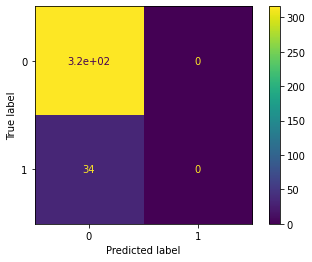

In [125]:
tr_data_pca = new_train_data.copy()
tr_labels_pca = new_train_labels.copy()
tst_data_pca = new_test_data.copy()
tst_labels_pca = test_labels.copy()

tr_data_pca_test = tr_data_pca[range(100)]
tr_data_pca_test = tr_data_pca_test.to_numpy()
tst_data_pca_test = tst_data_pca[range(100)]
tst_data_pca_test = tst_data_pca_test.to_numpy()

newpca = PCA(5)
newpca.fit(tr_data_pca_test.astype('float32'))
trdata = newpca.transform(tr_data_pca_test)


tr_data_new = pd.DataFrame(trdata)
tst_data_new = pd.DataFrame(newpca.transform(tst_data_pca_test).real)


newsvm = SVC(kernel='linear', gamma=0.5)
newsvm.fit(tr_data_new, tr_labels_pca)
y_pred = newsvm.predict(tst_data_new)
accuracy = np.count_nonzero((int(y_pred[0])==np.array(tst_labels_pca[0])).astype('uint8'))/ tst_labels_pca.shape[0] * 100
print("accuracy is {} percent. \n".format(accuracy))
y = [int(y_pred[i]) for i in range(350)]

disp = ConfusionMatrixDisplay(confusion_matrix(test_labels, y, labels = [0,1], sample_weight=None, normalize = None), display_labels = [0,1])
disp.plot()